In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from pathlib import Path

# Input folders
base_path = Path("/kaggle/input/total-dataset")
aug_real_path = Path("/kaggle/input/total-dataset/augmented_real_batch1/kaggle/working/augmented_real_batch1")

batch_paths = [
    "face_data_batch_1",
    "face_data_batch_2",
    "face_data_batch_3"
]

total_real = 0
total_fake = 0

# Count real and fake from all 3 batches
for batch in batch_paths:
    real_dir = base_path / batch / "kaggle/working/face_data/real"
    fake_dir = base_path / batch / "kaggle/working/face_data/fake"
    
    real_count = len(list(real_dir.glob("*.jpg"))) if real_dir.exists() else 0
    fake_count = len(list(fake_dir.glob("*.jpg"))) if fake_dir.exists() else 0
    
    print(f"📦 {batch} — 🟢 Real: {real_count}, 🔴 Fake: {fake_count}")
    
    total_real += real_count
    total_fake += fake_count

# Add augmented real
aug_count = len(list(aug_real_path.glob("*.jpg")))
print(f"\n🎨 Augmented Real Batch — 🟢 Real: {aug_count}")

total_real += aug_count

# Final totals
print("\n📊 TOTAL IMAGE COUNTS")
print(f"🟢 Real (original + augmented): {total_real}")
print(f"🔴 Fake: {total_fake}")
print(f"🧮 Combined total: {total_real + total_fake}")


In [ ]:
from pathlib import Path

# Input folders
base_path = Path("/kaggle/input/total-dataset")
aug_real_path = Path("/kaggle/input/total-dataset/augmented_real_batch1/kaggle/working/augmented_real_batch1")

batch_paths = [
    "face_data_batch_1",
    "face_data_batch_2",
    "face_data_batch_3"
]

total_real = 0
total_fake = 0

# Count real and fake from all 3 batches
for batch in batch_paths:
    real_dir = base_path / batch / "kaggle/working/face_data/real"
    fake_dir = base_path / batch / "kaggle/working/face_data/fake"
    
    real_count = len(list(real_dir.glob("*.jpg"))) if real_dir.exists() else 0
    fake_count = len(list(fake_dir.glob("*.jpg"))) if fake_dir.exists() else 0
    
    print(f"📦 {batch} — 🟢 Real: {real_count}, 🔴 Fake: {fake_count}")
    
    total_real += real_count
    total_fake += fake_count

# Add augmented real
aug_count = len(list(aug_real_path.glob("*.jpg")))
print(f"\n🎨 Augmented Real Batch — 🟢 Real: {aug_count}")

total_real += aug_count

# Final totals
print("\n📊 TOTAL IMAGE COUNTS")
print(f"🟢 Real (original + augmented): {total_real}")
print(f"🔴 Fake: {total_fake}")
print(f"🧮 Combined total: {total_real + total_fake}")


In [1]:
!rm -rf /kaggle/working/*


📦 TEST — fake: 100%|██████████| 137/137 [04:45<00:00,  2.08s/it]



✅ SPLIT COMPLETE!


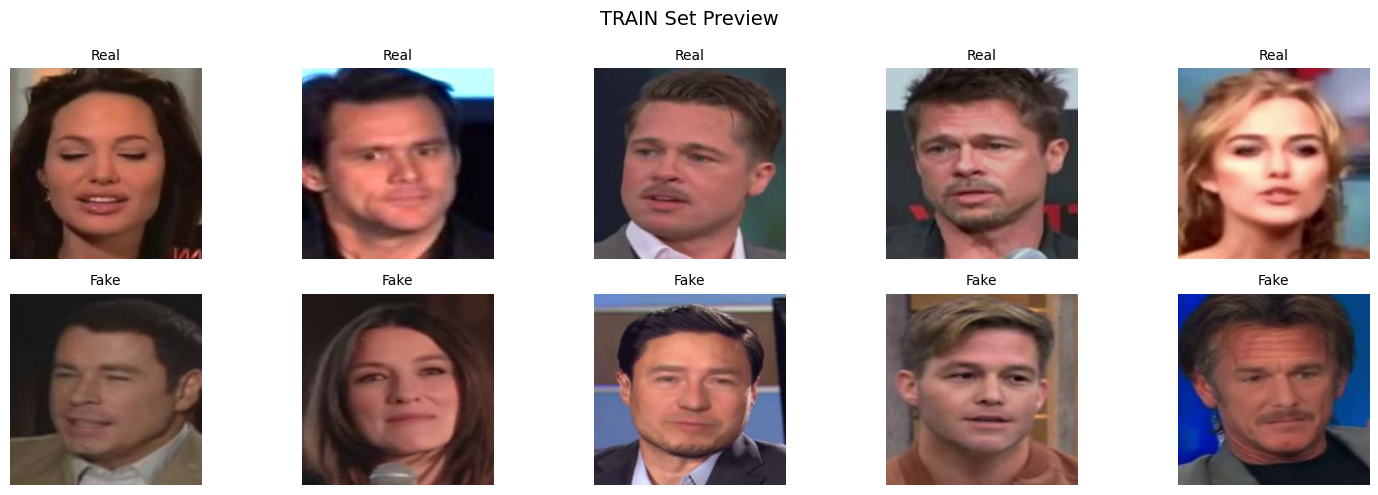

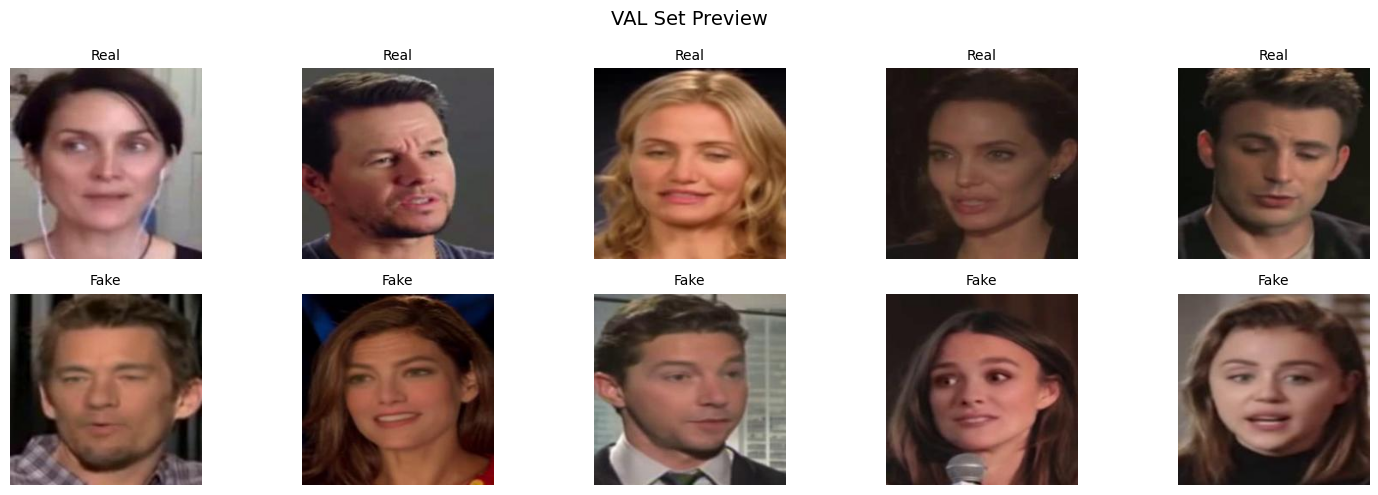

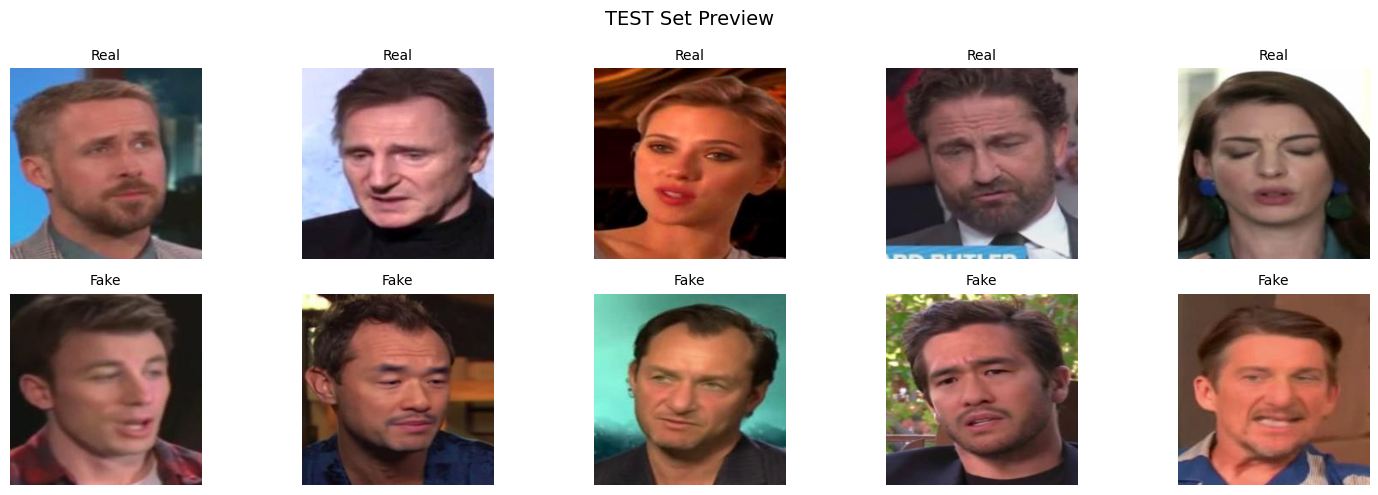

📦 Zipping split_dataset for future use...
✅ Done: split_dataset.zip is ready to download from the sidebar.


In [2]:
import os
from pathlib import Path
from collections import defaultdict
import shutil
import random
from tqdm import tqdm

# Paths
base_path = Path("/kaggle/input/total-dataset")
aug_real_path = base_path / "augmented_real_batch1/kaggle/working/augmented_real_batch1"
batch_paths = ["face_data_batch_1", "face_data_batch_2", "face_data_batch_3"]

# Output
output_root = Path("/kaggle/working/split_dataset")
for split in ['train', 'val', 'test']:
    for label in ['real', 'fake']:
        (output_root / split / label).mkdir(parents=True, exist_ok=True)

# Helper: Extract video ID
def get_video_id(fname):
    return "_".join(fname.name.split("_")[:2])  # e.g. id36_0006

# 🟢 Gather real image paths (original + augmented)
real_images = []
# From original batches
for batch in batch_paths:
    real_dir = base_path / batch / "kaggle/working/face_data/real"
    if real_dir.exists():
        real_images += list(real_dir.glob("*.jpg"))
# From augmented batch
if aug_real_path.exists():
    real_images += list(aug_real_path.glob("*.jpg"))

# 🔴 Gather fake image paths
fake_images = []
for batch in batch_paths:
    fake_dir = base_path / batch / "kaggle/working/face_data/fake"
    if fake_dir.exists():
        fake_images += list(fake_dir.glob("*.jpg"))

# Group by video_id
def group_by_video_id(paths):
    grouped = defaultdict(list)
    for path in paths:
        vid = get_video_id(path)
        grouped[vid].append(path)
    return grouped

real_grouped = group_by_video_id(real_images)
fake_grouped = group_by_video_id(fake_images)

# Split video IDs
def split_ids(ids, train_ratio=0.7, val_ratio=0.1, seed=42):
    random.seed(seed)
    ids = list(ids)
    random.shuffle(ids)
    n = len(ids)
    train_cut = int(n * train_ratio)
    val_cut = int(n * (train_ratio + val_ratio))
    return ids[:train_cut], ids[train_cut:val_cut], ids[val_cut:]

real_ids = list(real_grouped.keys())
fake_ids = list(fake_grouped.keys())

real_train, real_val, real_test = split_ids(real_ids)
fake_train, fake_val, fake_test = split_ids(fake_ids)

# Helper: Move grouped frames
def move_grouped_images(grouped_dict, ids, label, split):
    for vid in tqdm(ids, desc=f"📦 {split.upper()} — {label}"):
        for path in grouped_dict[vid]:
            dest = output_root / split / label / path.name
            shutil.copyfile(path, dest)

# Move files
move_grouped_images(real_grouped, real_train, 'real', 'train')
move_grouped_images(real_grouped, real_val, 'real', 'val')
move_grouped_images(real_grouped, real_test, 'real', 'test')

move_grouped_images(fake_grouped, fake_train, 'fake', 'train')
move_grouped_images(fake_grouped, fake_val, 'fake', 'val')
move_grouped_images(fake_grouped, fake_test, 'fake', 'test')

print("\n✅ SPLIT COMPLETE!")


import matplotlib.pyplot as plt
from PIL import Image

# Helper to visualize 5 real + 5 fake images from a given split
def show_split_preview(split_name):
    real_dir = output_root / split_name / "real"
    fake_dir = output_root / split_name / "fake"
    
    real_imgs = random.sample(list(real_dir.glob("*.jpg")), 5)
    fake_imgs = random.sample(list(fake_dir.glob("*.jpg")), 5)

    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    for i in range(5):
        axs[0, i].imshow(Image.open(real_imgs[i]))
        axs[0, i].set_title("Real", fontsize=10)
        axs[0, i].axis("off")
        
        axs[1, i].imshow(Image.open(fake_imgs[i]))
        axs[1, i].set_title("Fake", fontsize=10)
        axs[1, i].axis("off")
    
    plt.suptitle(f"{split_name.upper()} Set Preview", fontsize=14)
    plt.tight_layout()
    plt.show()

# Show previews
for split in ["train", "val", "test"]:
    show_split_preview(split)

import shutil

zip_path = "/kaggle/working/split_dataset.zip"
split_path = "/kaggle/working/split_dataset"

print("📦 Zipping split_dataset for future use...")
shutil.make_archive(base_name=zip_path.replace(".zip", ""), format='zip', root_dir=split_path)
print("✅ Done: split_dataset.zip is ready to download from the sidebar.")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# 📁 Paths
DATA_DIR = "/kaggle/working/split_dataset"
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Datasets
train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transform)
val_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=transform)
test_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 🧠 Class weights (real = 2x more important)
class_weights = torch.tensor([1.0, 2.0]).to(device)  # [fake, real]
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 🧠 Model setup
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 📊 Tracking
train_accs, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    correct = total = 0
    running_loss = 0.0

    for imgs, labels in tqdm(train_loader, desc=f"🔁 Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    train_acc = 100 * correct / total
    train_accs.append(train_acc)

    # 🔍 Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_accs.append(val_acc)

    print(f"📊 Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

# 📈 Plot Accuracy
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()
